In [27]:
import pandas as pd

In [28]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests # Para cargar datos desde URL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

print("Configuración inicial y librerías cargadas.")

# URL del dataset original
url_data = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

print("\n--- Paso 0.1: Carga de Datos desde URL ---")
try:
    # Intenta obtener la respuesta de la URL
    respuesta = requests.get(url_data)
    respuesta.raise_for_status() # Lanza un error si la solicitud HTTP no fue exitosa

    # Carga los datos JSON directamente en un DataFrame de pandas
    df_clientes = pd.read_json(url_data)

    print("¡Datos cargados exitosamente en un DataFrame!")
    print("\nPrimeras 5 filas del DataFrame (df_clientes):")
    print(df_clientes.head())

    print("\nInformación general del DataFrame (df_clientes.info()):")
    df_clientes.info()

except requests.exceptions.RequestException as e:
    print(f"¡Error de conexión! No se pudo acceder a la URL. Por favor, verifica tu conexión a internet o la URL: {e}")
except Exception as e:
    print(f"¡Error al procesar los datos! Asegúrate de que el archivo JSON es válido y accesible: {e}")

print("\n--- Paso 0.2: Verificación de Duplicados por customerID ---")
num_duplicados_id = df_clientes['customerID'].duplicated().sum()

if num_duplicados_id > 0:
    print(f"¡Se encontraron {num_duplicados_id} clientes duplicados basándose en 'customerID'!")
    print("Eliminando registros duplicados...")
    df_clientes.drop_duplicates(subset=['customerID'], inplace=True)
    print(f"Duplicados eliminados. Ahora el número de filas es: {df_clientes.shape[0]}")
else:
    print("¡No se encontraron clientes duplicados por 'customerID'!")

Configuración inicial y librerías cargadas.

--- Paso 0.1: Carga de Datos desde URL ---
¡Datos cargados exitosamente en un DataFrame!

Primeras 5 filas del DataFrame (df_clientes):
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            inter

In [29]:
print("--- Paso 1: Aplanando columnas con diccionarios y corrigiendo 'TotalCharges' ---")

# Identificando y aplanando columnas que contienen diccionarios
columnas_a_aplanar = []
for col in df_clientes.columns:
    if len(df_clientes) > 0 and pd.notna(df_clientes[col].iloc[0]) and isinstance(df_clientes[col].iloc[0], dict):
        columnas_a_aplanar.append(col)

if columnas_a_aplanar:
    print(f"Columnas identificadas con diccionarios que necesitan ser aplanadas: {columnas_a_aplanar}")
    for col_dict in columnas_a_aplanar:
        print(f"Aplanando la columna '{col_dict}'...")
        # Normalizar el JSON y prefijar las nuevas columnas para evitar conflictos
        df_temp = pd.json_normalize(df_clientes[col_dict])
        df_temp.columns = [f"{col_dict}_{sub_col}" for sub_col in df_temp.columns]
        df_clientes = pd.concat([df_clientes.drop(columns=[col_dict]), df_temp], axis=1)
    print("¡Columnas aplanadas con éxito!")
else:
    print("No se encontraron columnas de diccionario para aplanar.")

print("\nNombres de todas las columnas DESPUÉS del aplanamiento:")
print(df_clientes.columns.tolist())

# --- Tratamiento específico de 'TotalCharges' ---
# Identificamos el nombre real de la columna TotalCharges después del aplanamiento
nombre_columna_cargos_totales = 'account_Charges.Total' # Nombre esperado tras el aplanamiento de 'account'

if nombre_columna_cargos_totales in df_clientes.columns:
    print(f"\n--- Intentando convertir '{nombre_columna_cargos_totales}' a numérico y manejando vacíos/nulos: ---")
    # Convertir a numérico, forzando errores a NaN
    df_clientes[nombre_columna_cargos_totales] = pd.to_numeric(df_clientes[nombre_columna_cargos_totales], errors='coerce')

    # Contar y rellenar los valores nulos que resultaron de la conversión
    null_count_tc = df_clientes[nombre_columna_cargos_totales].isnull().sum()
    if null_count_tc > 0:
        print(f"Se encontraron {null_count_tc} valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
        print(f"Rellenando los valores nulos con 0 para '{nombre_columna_cargos_totales}'.")
        # Using .loc to avoid SettingWithCopyWarning/FutureWarning
        df_clientes.loc[:, nombre_columna_cargos_totales] = df_clientes[nombre_columna_cargos_totales].fillna(0)
    else:
        print(f"No se encontraron valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
else:
    print(f"\n¡La columna '{nombre_columna_cargos_totales}' NO se encontró en el DataFrame después del aplanamiento!")
    print("Por favor, revisa los nombres de las columnas para encontrar el correcto.")

print("\nTipos de datos después del aplanamiento y limpieza de 'TotalCharges':")
df_clientes.info()

--- Paso 1: Aplanando columnas con diccionarios y corrigiendo 'TotalCharges' ---
Columnas identificadas con diccionarios que necesitan ser aplanadas: ['customer', 'phone', 'internet', 'account']
Aplanando la columna 'customer'...
Aplanando la columna 'phone'...
Aplanando la columna 'internet'...
Aplanando la columna 'account'...
¡Columnas aplanadas con éxito!

Nombres de todas las columnas DESPUÉS del aplanamiento:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges.Monthly', 'account_Charges.Total']

--- Intentando convertir 'account_Charges.Total' a numérico y manejando vacíos/nulos: ---
Se e

In [30]:
# ... (Código previo del Paso 0 y Paso 1 sin cambios) ...

print("--- Paso 2: Creación de 'Cuentas_Diarias' y Estandarización de Variables ---")

# 1. Creación de la columna 'Cuentas_Diarias'
columna_facturacion_mensual = 'account_Charges.Monthly'
if columna_facturacion_mensual in df_clientes.columns:
    dias_en_mes = 30
    df_clientes['Cuentas_Diarias'] = pd.to_numeric(df_clientes[columna_facturacion_mensual], errors='coerce') / dias_en_mes
    df_clientes['Cuentas_Diarias'].fillna(0, inplace=True) # Rellenar nulos si los hubiera

    print(f"Columna 'Cuentas_Diarias' creada y calculada a partir de '{columna_facturacion_mensual}'.")
    print("Primeras 5 filas con la nueva columna:")
    print(df_clientes[['customerID', columna_facturacion_mensual, 'Cuentas_Diarias']].head())
else:
    print(f"Error: La columna '{columna_facturacion_mensual}' no se encontró. No se pudo crear 'Cuentas_Diarias'.")

# 2. Convertir valores binarios (Sí/No, Male/Female, etc.) a 1 y 0
print("\n--- Convirtiendo valores binarios a numéricos (1 y 0): ---")
mapeos_binarios = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0,
    'No phone service': 0,
    'No internet service': 0
}

# Columnas binarias a transformar (revisar nombres exactos después del aplanamiento)
columnas_binarias_a_transformar = [
    'Churn',
    'customer_Partner',
    'customer_Dependents',
    'phone_PhoneService',
    'phone_MultipleLines',
    'internet_OnlineSecurity',
    'internet_OnlineBackup',
    'internet_DeviceProtection',
    'internet_TechSupport',
    'internet_StreamingTV',
    'internet_StreamingMovies',
    'account_PaperlessBilling',
    'customer_gender' # Incluir el género aquí
]

for col in columnas_binarias_a_transformar:
    if col in df_clientes.columns and df_clientes[col].dtype == 'object': # Solo procesar si es de tipo objeto
        print(f"Procesando columna binaria '{col}' (Valores únicos antes: {df_clientes[col].unique()})...")
        df_clientes[col] = df_clientes[col].replace(mapeos_binarios)
        print(f"Valores únicos después: {df_clientes[col].unique()}")
    elif col in df_clientes.columns:
        print(f"Columna '{col}' ya es numérica o no es un objeto, saltando conversión binaria.")
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para conversión binaria.")

# --- INICIO DE LA CORRECCIÓN PARA CHURN ---
# Después de intentar mapear 'Churn', verifica y maneja los valores restantes no numéricos
if 'Churn' in df_clientes.columns and (df_clientes['Churn'] == '').any():
    print("\nDetectados valores vacíos (cadenas vacías) en la columna 'Churn'.")
    # Convertir cadenas vacías a NaN y luego eliminar las filas con NaN
    original_rows = df_clientes.shape[0]
    df_clientes['Churn'] = df_clientes['Churn'].replace('', np.nan)
    df_clientes.dropna(subset=['Churn'], inplace=True)
    df_clientes['Churn'] = df_clientes['Churn'].astype(int) # Asegurarse de que sea int
    print(f"Se eliminaron {original_rows - df_clientes.shape[0]} filas con 'Churn' vacío. Nueva cantidad de filas: {df_clientes.shape[0]}.")
    print(f"Valores únicos de 'Churn' después de limpieza: {df_clientes['Churn'].unique()}")
# --- FIN DE LA CORRECCIÓN PARA CHURN ---


# 3. Renombrar columnas para mayor claridad
print("\n--- Renombrando columnas para mayor claridad: ---")
nuevos_nombres_columnas = {
    'customerID': 'ID_Cliente',
    'customer_gender': 'Genero_Cliente',
    'customer_SeniorCitizen': 'Cliente_TerceraEdad',
    'customer_Partner': 'Cliente_Pareja',
    'customer_Dependents': 'Cliente_Dependientes',
    'customer_tenure': 'Antiguedad_Meses',
    'phone_PhoneService': 'Servicio_Telefono',
    'phone_MultipleLines': 'Multiples_Lineas',
    'internet_InternetService': 'Servicio_Internet',
    'internet_OnlineSecurity': 'Seguridad_Online',
    'internet_OnlineBackup': 'Respaldo_Online',
    'internet_DeviceProtection': 'Proteccion_Dispositivo',
    'internet_TechSupport': 'Soporte_Tecnico',
    'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Peliculas',
    'account_Contract': 'Tipo_Contrato',
    'account_PaperlessBilling': 'Facturacion_Electronica',
    'account_PaymentMethod': 'Metodo_Pago',
    'account_Charges.Monthly': 'Cargos_Mensuales',
    'account_Charges.Total': 'Cargos_Totales',
}

# Aplicar el renombramiento. Usamos .copy() para evitar SettingWithCopyWarning
df_clientes = df_clientes.rename(columns=nuevos_nombres_columnas).copy()

print("Columnas renombradas. Nuevos nombres (primeras 20):")
print(df_clientes.columns.tolist()[:20]) # Mostrar solo las primeras para no abrumar

print("\nTipos de datos después de la estandarización y transformación:")
df_clientes.info()
print("\nPrimeras 5 filas del DataFrame transformado:")
print(df_clientes.head())

--- Paso 2: Creación de 'Cuentas_Diarias' y Estandarización de Variables ---
Columna 'Cuentas_Diarias' creada y calculada a partir de 'account_Charges.Monthly'.
Primeras 5 filas con la nueva columna:
   customerID  account_Charges.Monthly  Cuentas_Diarias
0  0002-ORFBO                     65.6         2.186667
1  0003-MKNFE                     59.9         1.996667
2  0004-TLHLJ                     73.9         2.463333
3  0011-IGKFF                     98.0         3.266667
4  0013-EXCHZ                     83.9         2.796667

--- Convirtiendo valores binarios a numéricos (1 y 0): ---
Procesando columna binaria 'Churn' (Valores únicos antes: ['No' 'Yes' ''])...
Valores únicos después: [0 1 '']
Procesando columna binaria 'customer_Partner' (Valores únicos antes: ['Yes' 'No'])...
Valores únicos después: [1 0]
Procesando columna binaria 'customer_Dependents' (Valores únicos antes: ['Yes' 'No'])...
Valores únicos después: [1 0]
Procesando columna binaria 'phone_PhoneService' (Valores ú

Configuración inicial y librerías cargadas.

--- Paso 0.1: Carga de Datos desde URL ---
¡Datos cargados exitosamente en un DataFrame!

Primeras 5 filas del DataFrame (df_clientes):
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            inter

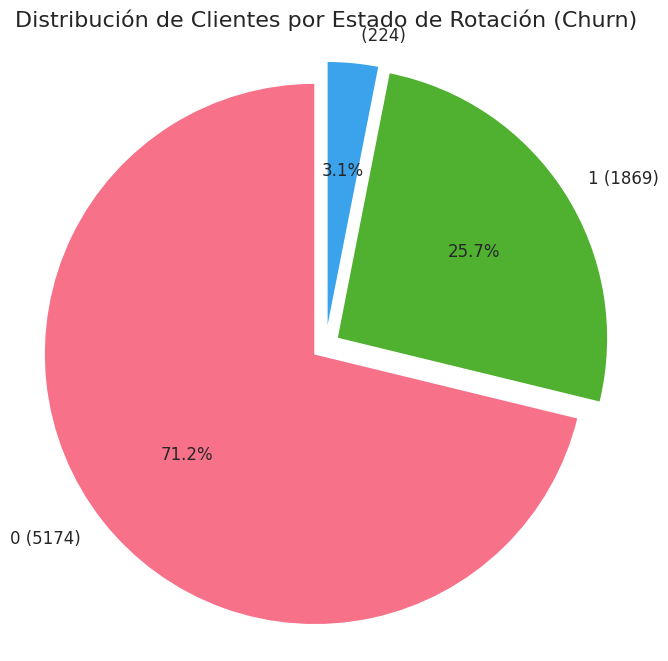

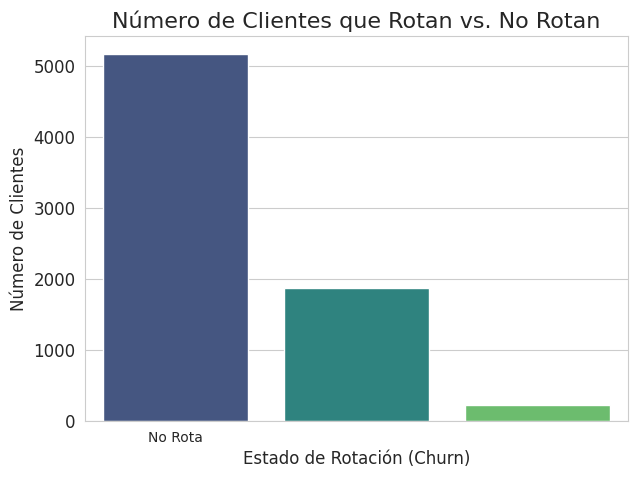


--- Matriz de Correlación entre Variables Numéricas ---


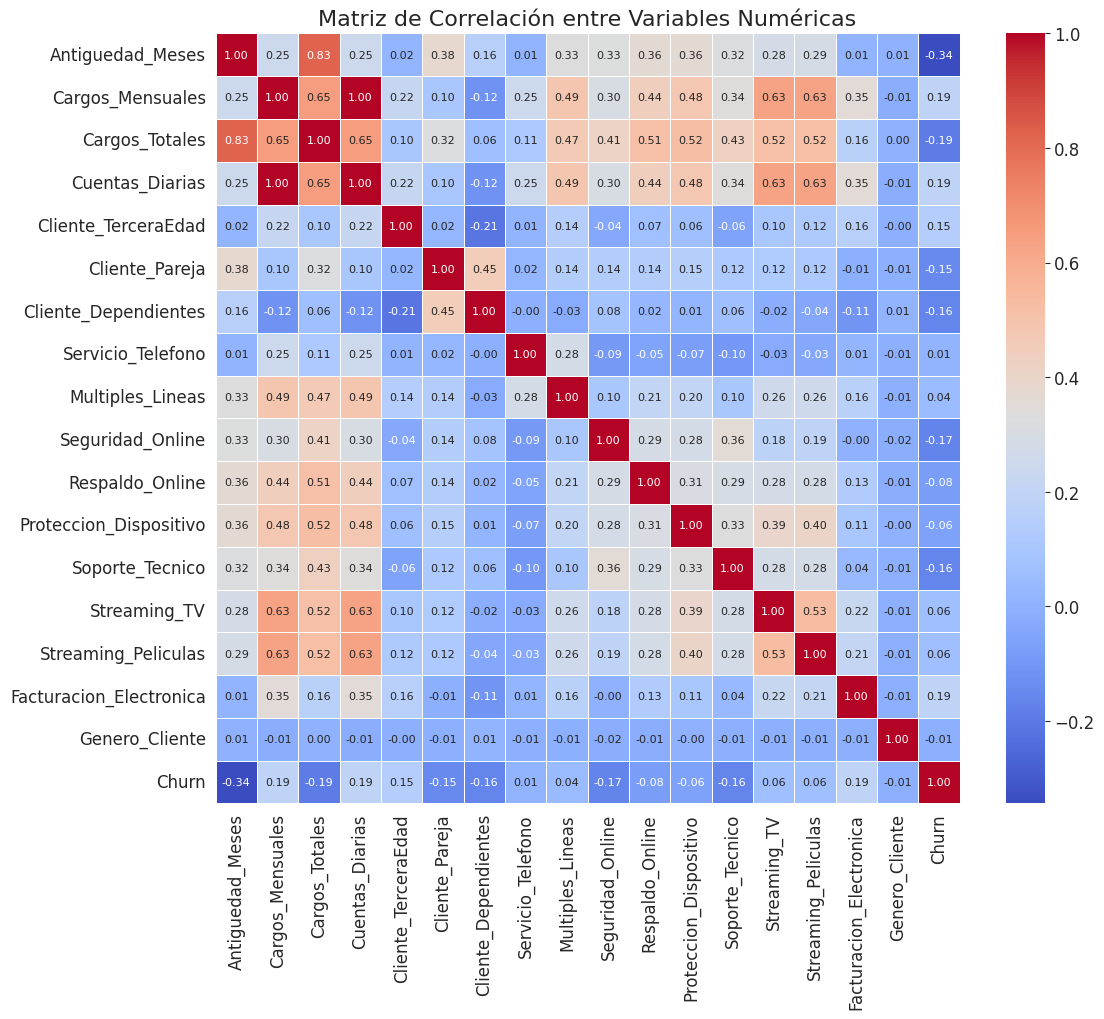


--- Análisis Dirigido: Churn por variables categóricas ---

Analizando 'Genero_Cliente' en relación con 'Churn'


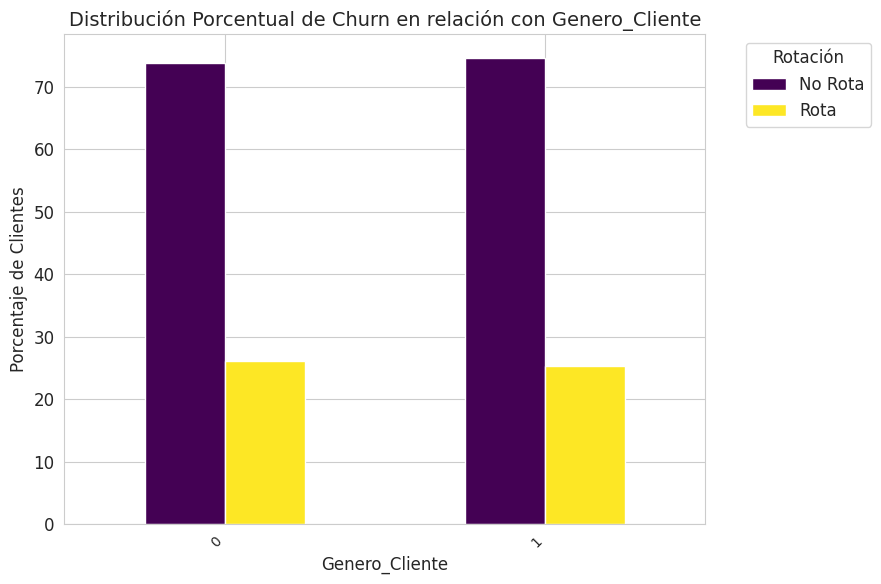


Analizando 'Cliente_TerceraEdad' en relación con 'Churn'


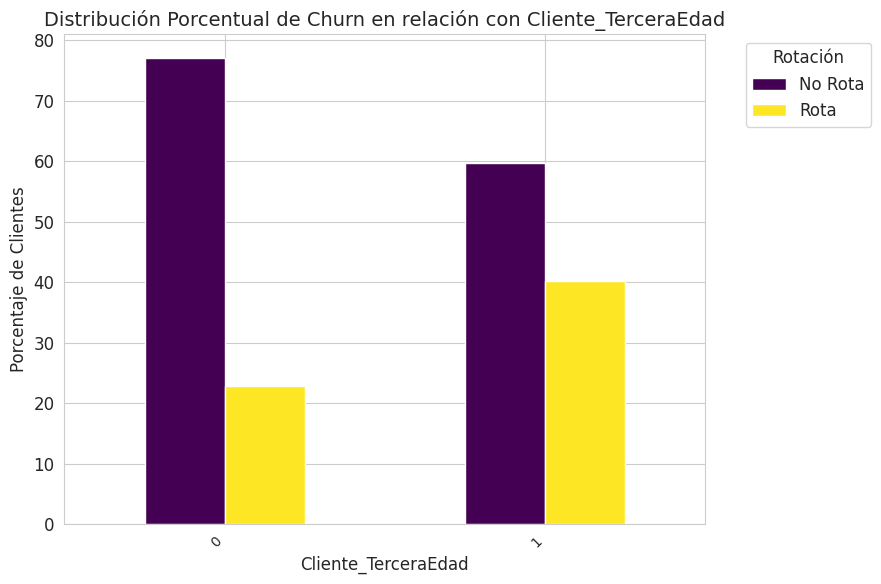


Analizando 'Cliente_Pareja' en relación con 'Churn'


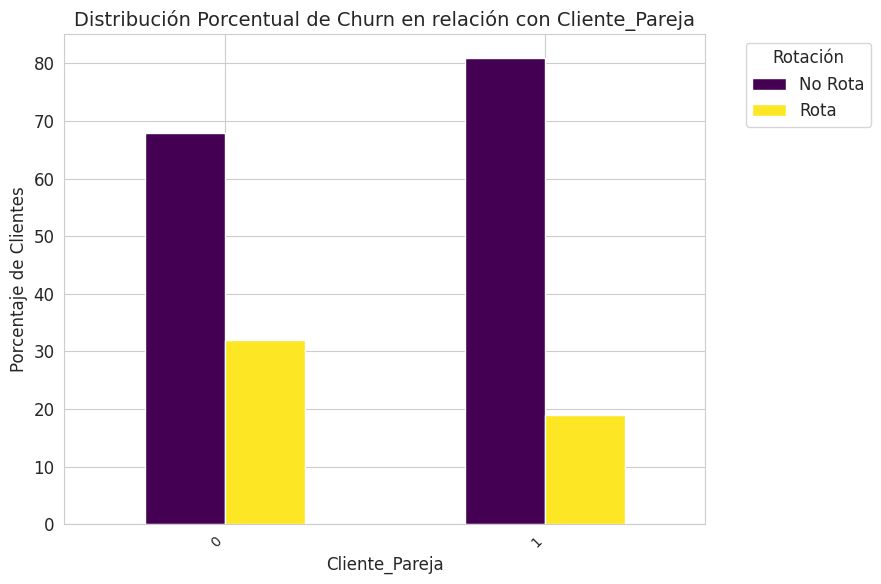


Analizando 'Cliente_Dependientes' en relación con 'Churn'


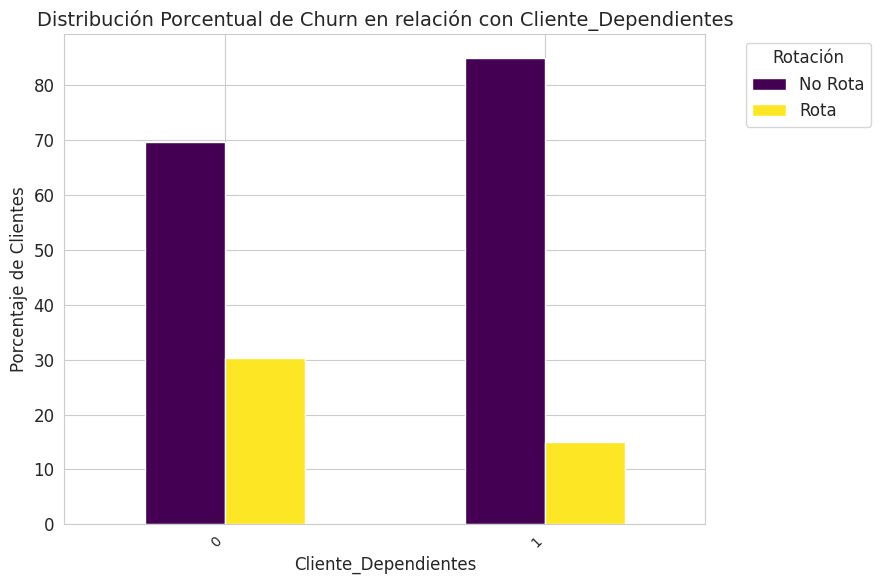


Analizando 'Servicio_Telefono' en relación con 'Churn'


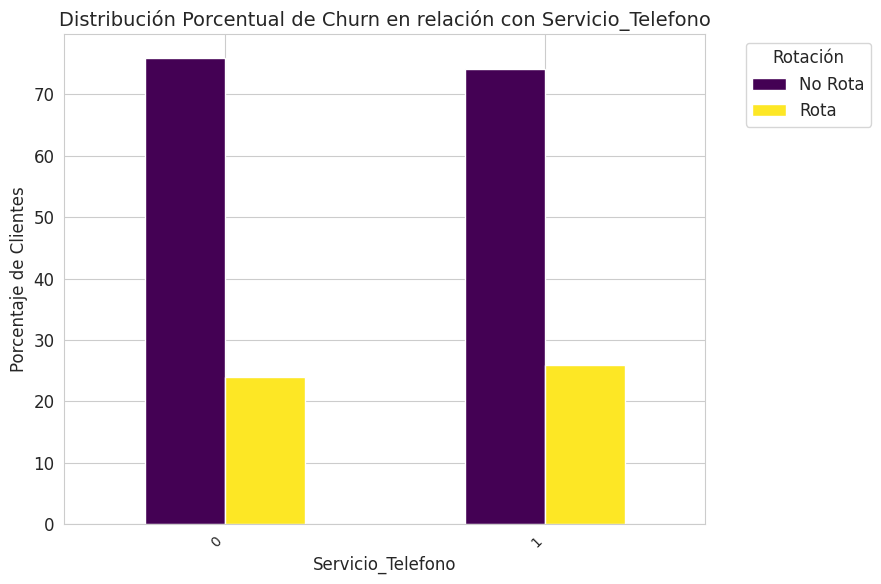


Analizando 'Multiples_Lineas' en relación con 'Churn'


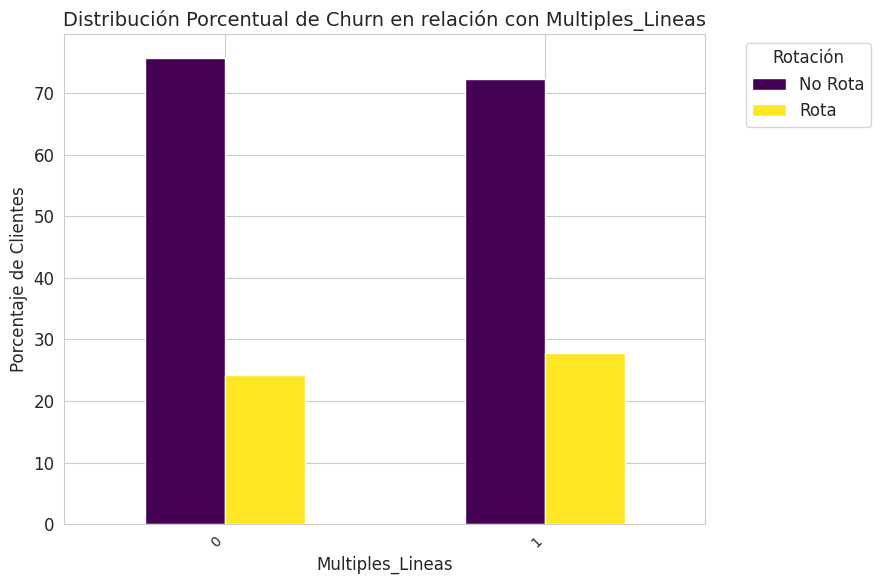


Analizando 'Servicio_Internet' en relación con 'Churn'


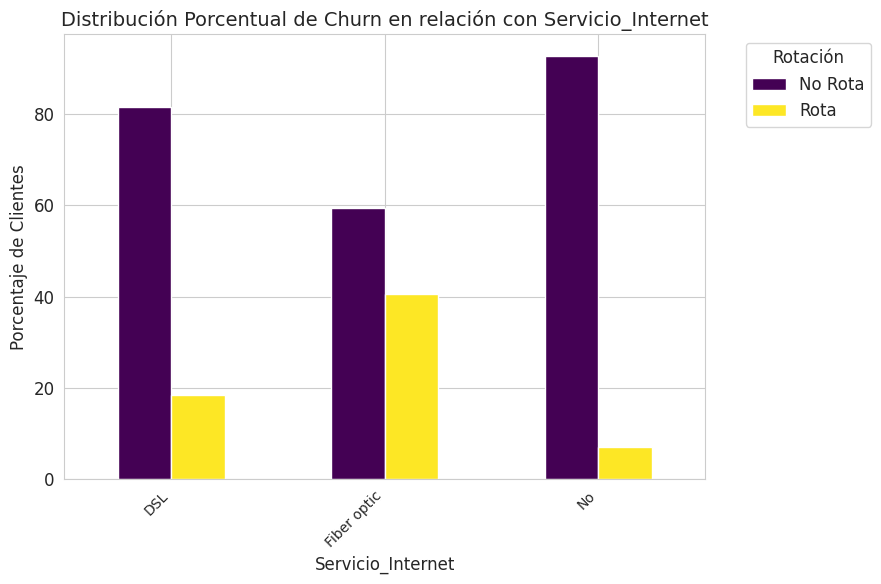


Analizando 'Seguridad_Online' en relación con 'Churn'


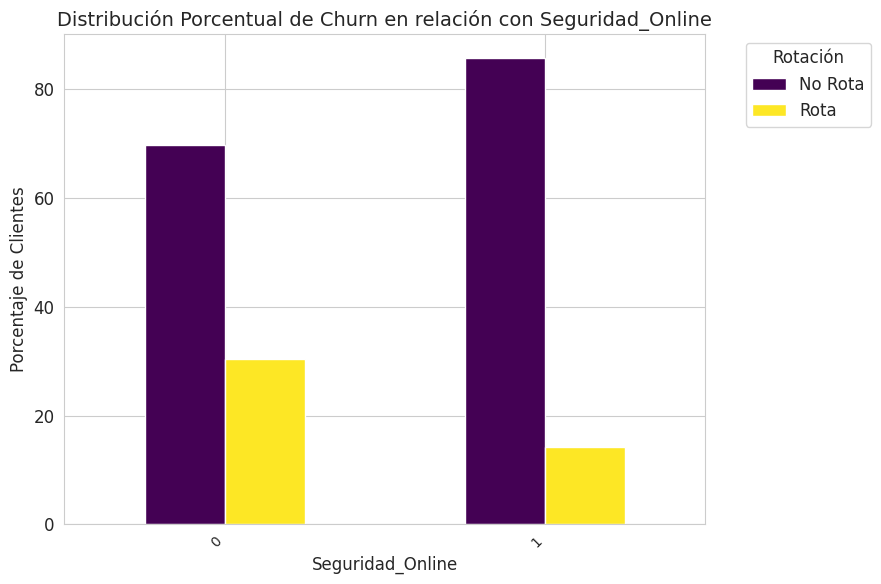


Analizando 'Respaldo_Online' en relación con 'Churn'


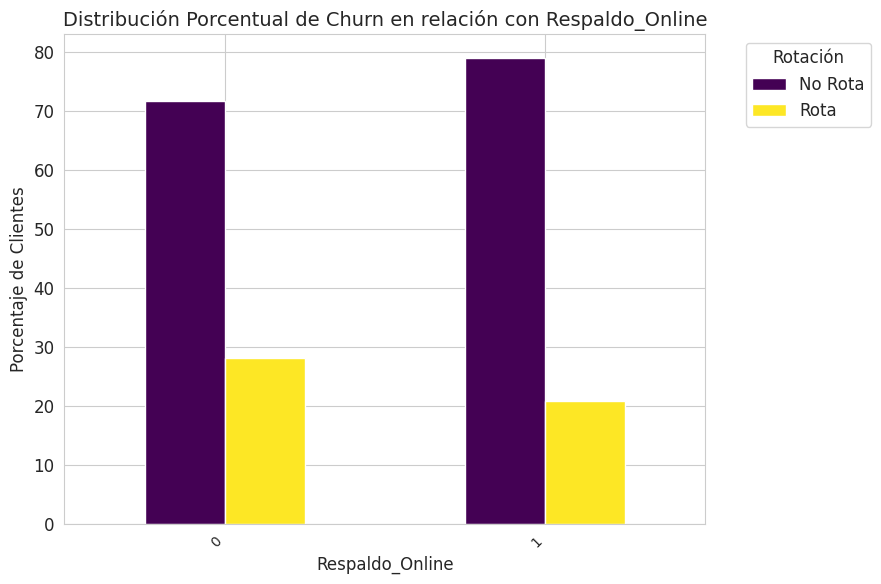


Analizando 'Proteccion_Dispositivo' en relación con 'Churn'


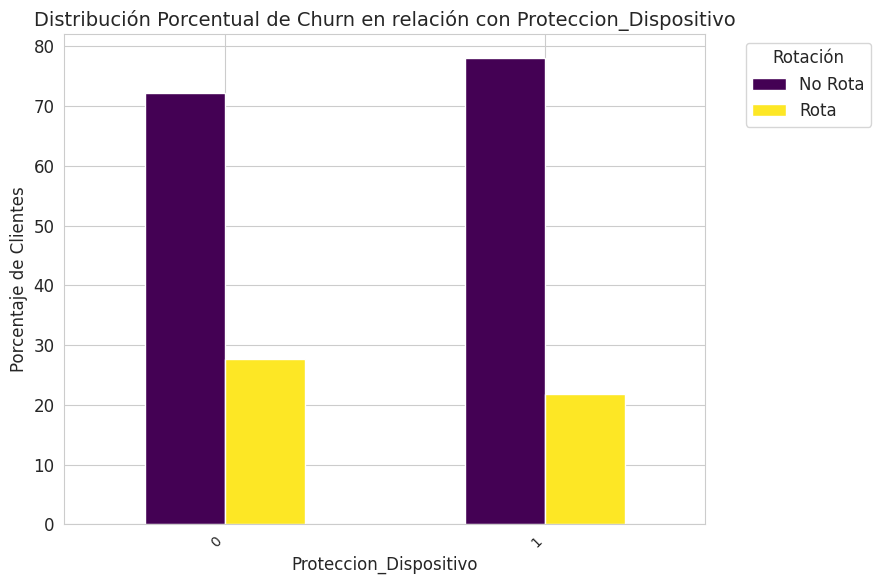


Analizando 'Soporte_Tecnico' en relación con 'Churn'


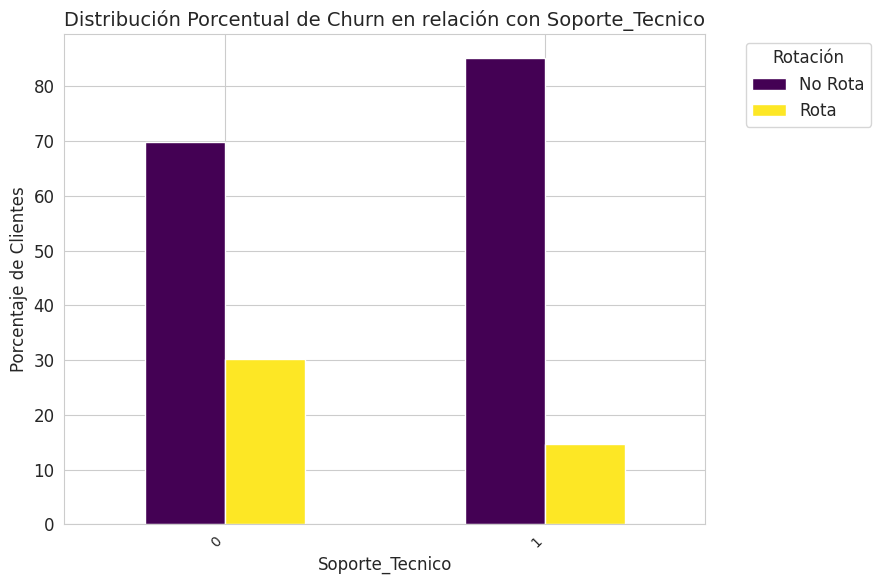


Analizando 'Streaming_TV' en relación con 'Churn'


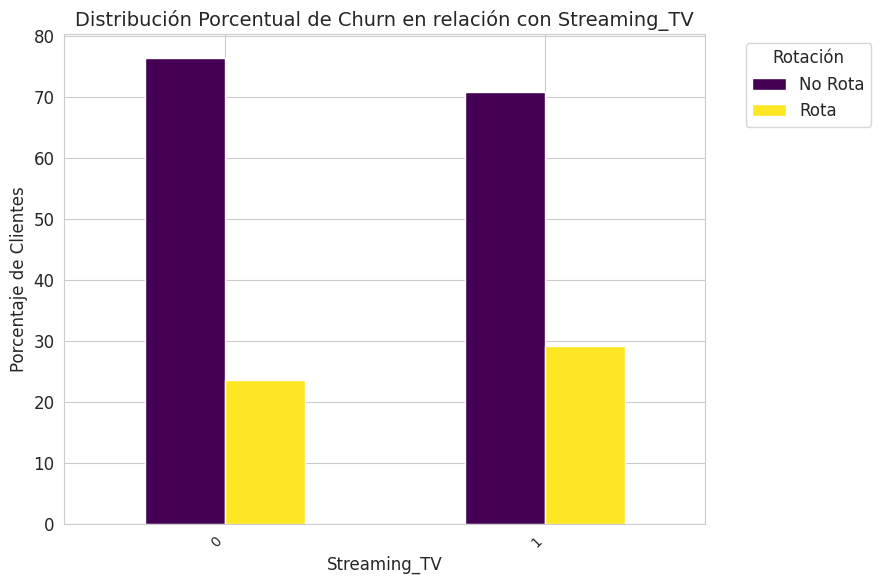


Analizando 'Streaming_Peliculas' en relación con 'Churn'


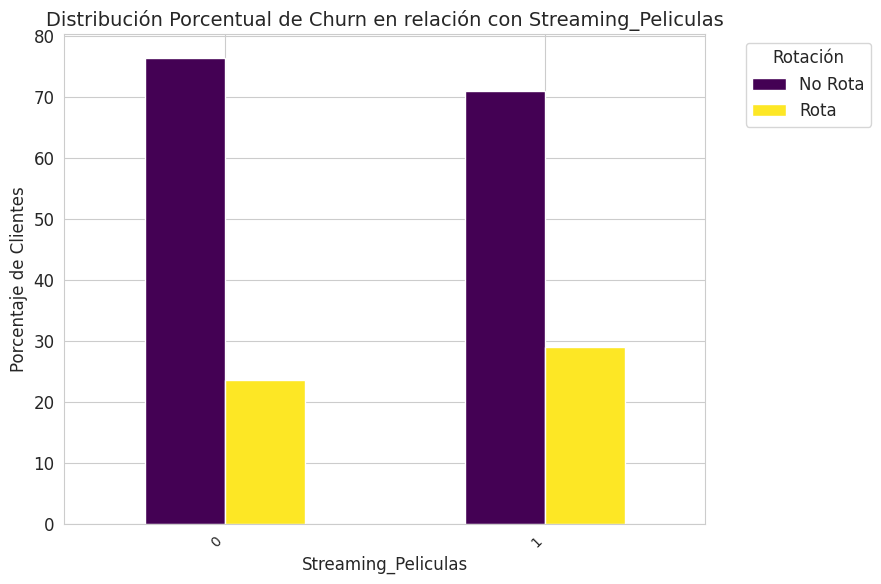


Analizando 'Tipo_Contrato' en relación con 'Churn'


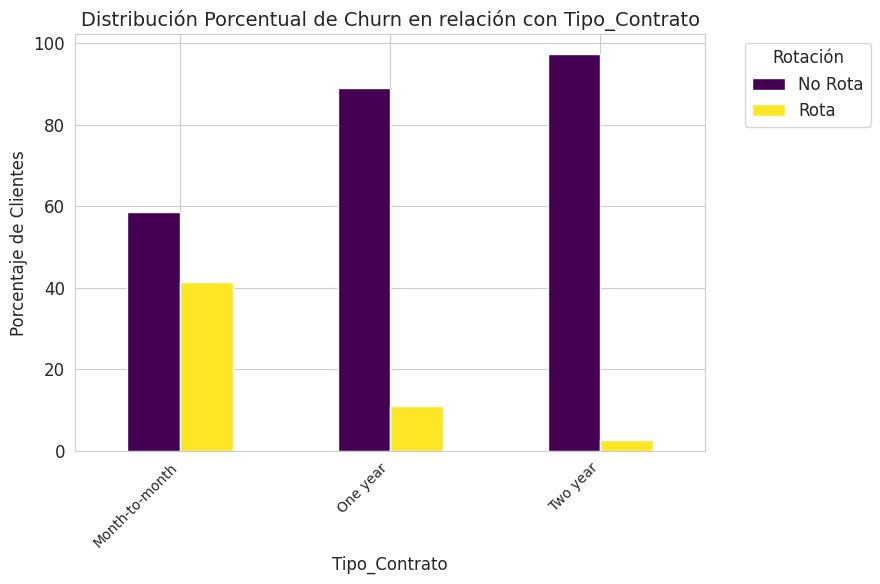


Analizando 'Facturacion_Electronica' en relación con 'Churn'


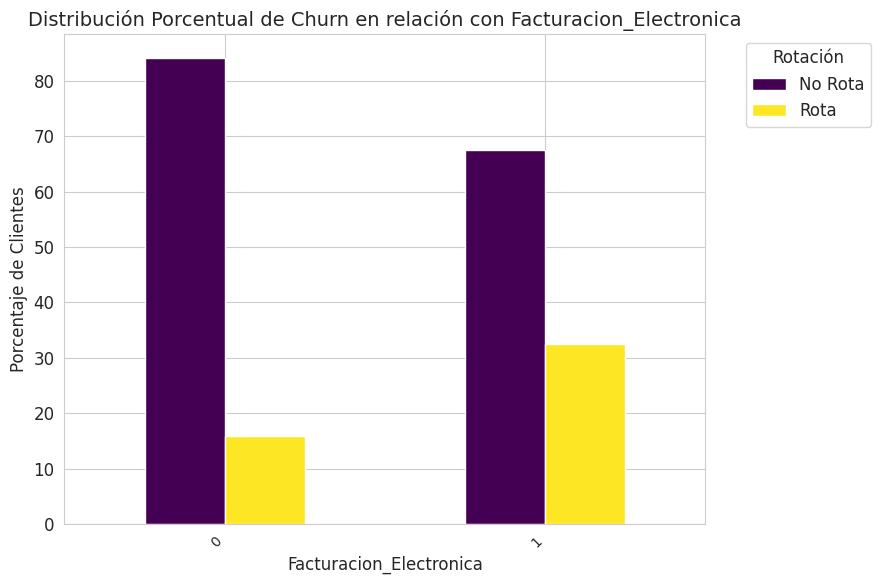


Analizando 'Metodo_Pago' en relación con 'Churn'


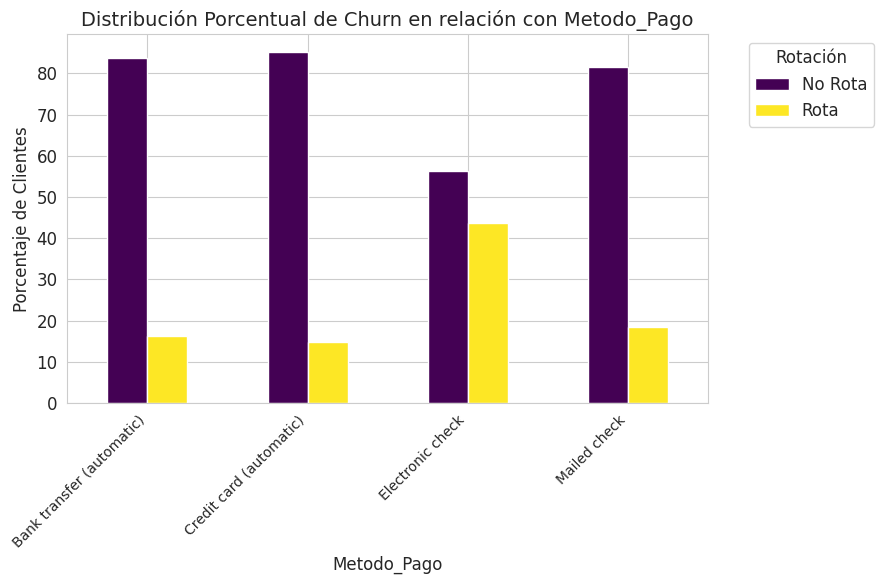


--- Análisis Dirigido: Churn por variables numéricas ---

Analizando 'Antiguedad_Meses' en relación con 'Churn'


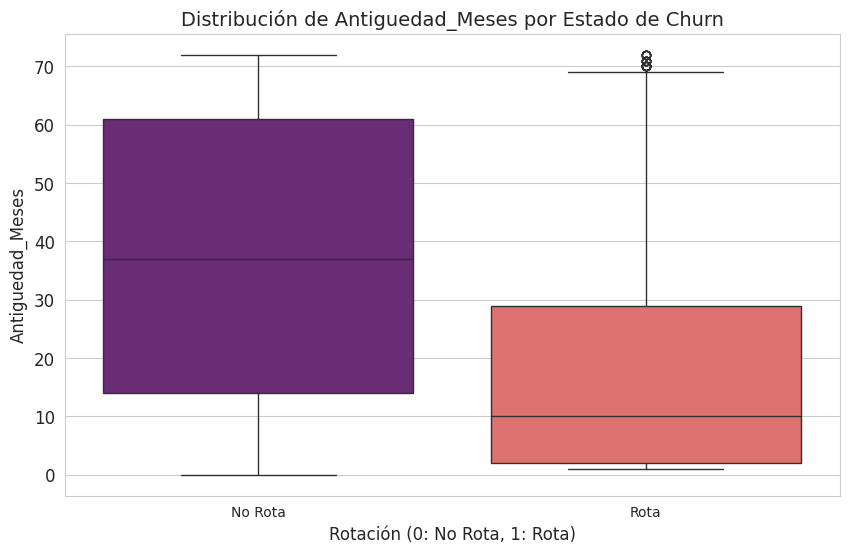

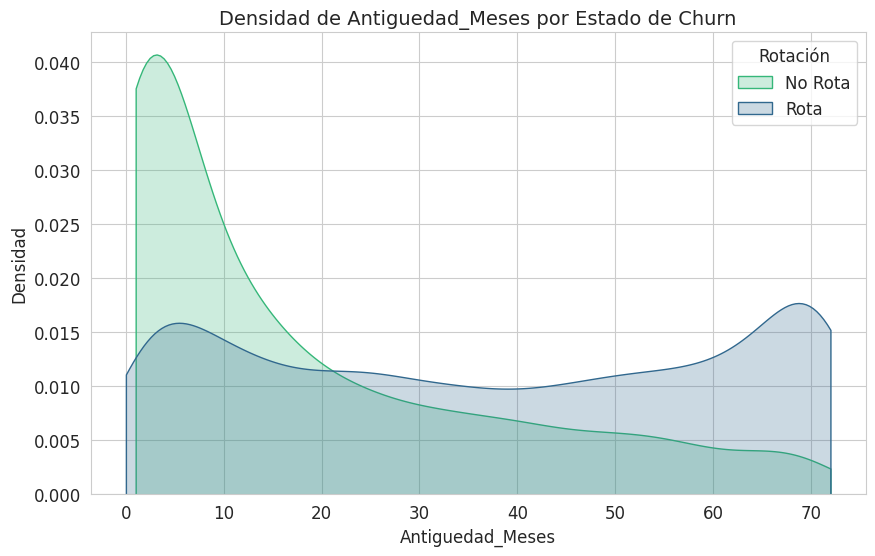


Analizando 'Cargos_Mensuales' en relación con 'Churn'


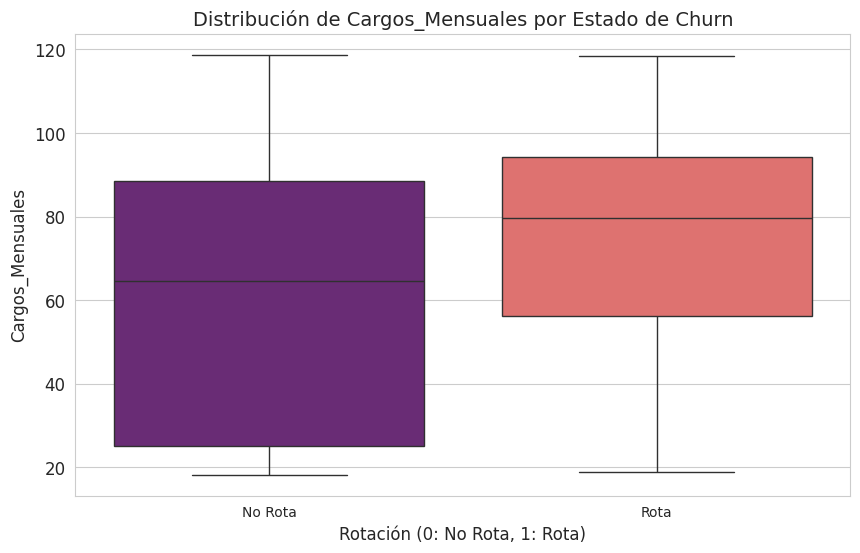

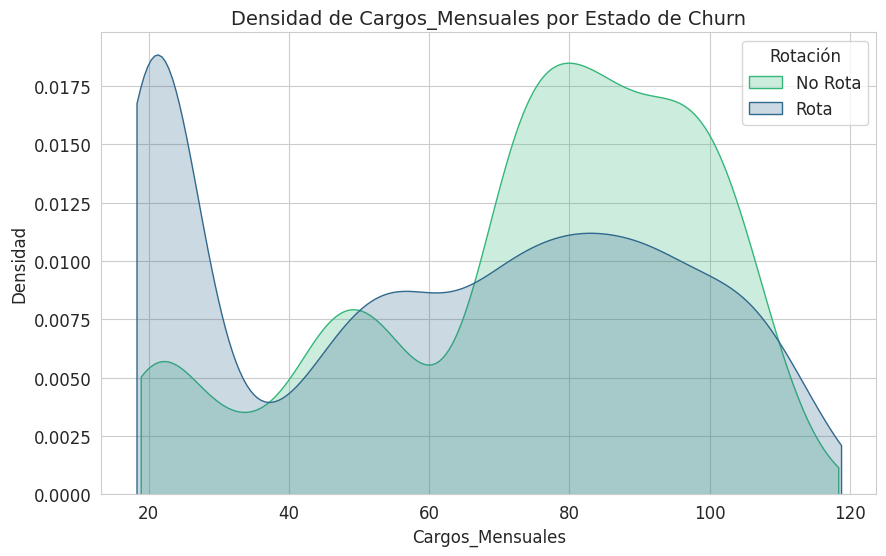


Analizando 'Cargos_Totales' en relación con 'Churn'


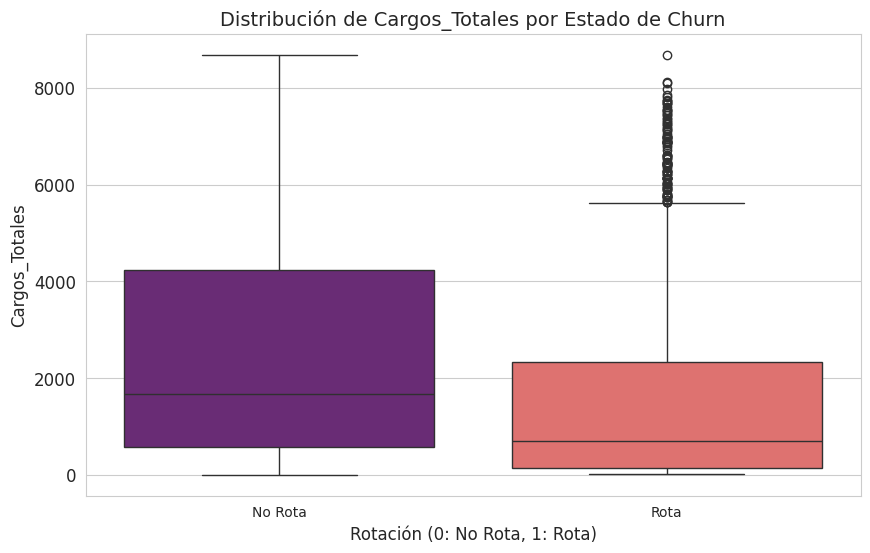

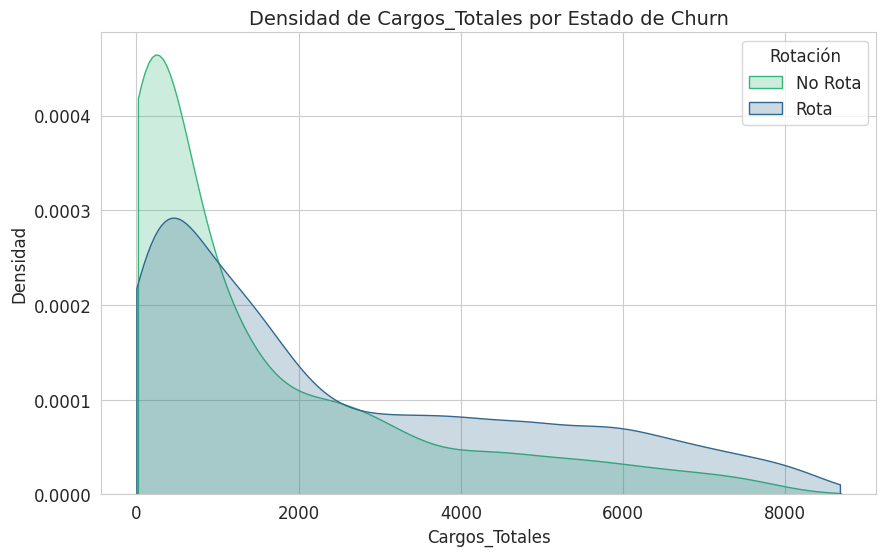


Analizando 'Cuentas_Diarias' en relación con 'Churn'


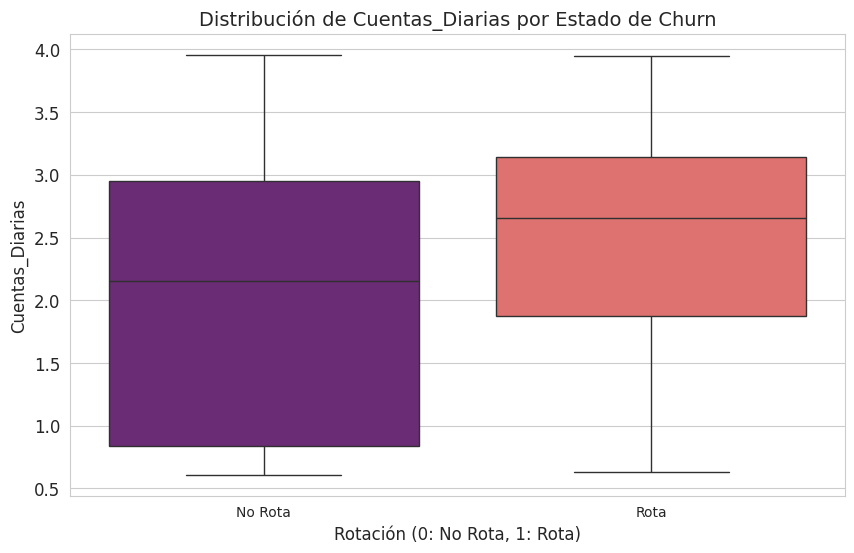

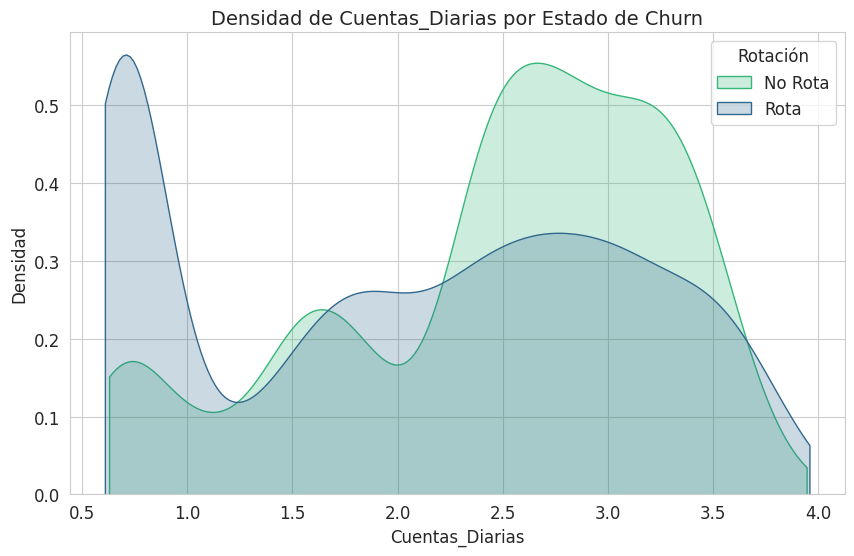


Análisis Exploratorio de Datos (EDA) completado.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests # Para cargar datos desde URL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

print("Configuración inicial y librerías cargadas.")

# URL del dataset original
url_data = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

print("\n--- Paso 0.1: Carga de Datos desde URL ---")
try:
    # Intenta obtener la respuesta de la URL
    respuesta = requests.get(url_data)
    respuesta.raise_for_status() # Lanza un error si la solicitud HTTP no fue exitosa

    # Carga los datos JSON directamente en un DataFrame de pandas
    df_clientes = pd.read_json(url_data)

    print("¡Datos cargados exitosamente en un DataFrame!")
    print("\nPrimeras 5 filas del DataFrame (df_clientes):")
    print(df_clientes.head())

    print("\nInformación general del DataFrame (df_clientes.info()):")
    df_clientes.info()

except requests.exceptions.RequestException as e:
    print(f"¡Error de conexión! No se pudo acceder a la URL. Por favor, verifica tu conexión a internet o la URL: {e}")
except Exception as e:
    print(f"¡Error al procesar los datos! Asegúrate de que el archivo JSON es válido y accesible: {e}")

print("\n--- Paso 0.2: Verificación de Duplicados por customerID ---")
num_duplicados_id = df_clientes['customerID'].duplicated().sum()

if num_duplicados_id > 0:
    print(f"¡Se encontraron {num_duplicados_id} clientes duplicados basándose en 'customerID'!")
    print("Eliminando registros duplicados...")
    df_clientes.drop_duplicates(subset=['customerID'], inplace=True)
    print(f"Duplicados eliminados. Ahora el número de filas es: {df_clientes.shape[0]}")
else:
    print("¡No se encontraron clientes duplicados por 'customerID'!")


print("--- Paso 1: Aplanando columnas con diccionarios y corrigiendo 'TotalCharges' ---")

# Identificando y aplanando columnas que contienen diccionarios
columnas_a_aplanar = []
for col in df_clientes.columns:
    if len(df_clientes) > 0 and pd.notna(df_clientes[col].iloc[0]) and isinstance(df_clientes[col].iloc[0], dict):
        columnas_a_aplanar.append(col)

if columnas_a_aplanar:
    print(f"Columnas identificadas con diccionarios que necesitan ser aplanadas: {columnas_a_aplanar}")
    for col_dict in columnas_a_aplanar:
        print(f"Aplanando la columna '{col_dict}'...")
        # Normalizar el JSON y prefijar las nuevas columnas para evitar conflictos
        df_temp = pd.json_normalize(df_clientes[col_dict])
        df_temp.columns = [f"{col_dict}_{sub_col}" for sub_col in df_temp.columns]
        df_clientes = pd.concat([df_clientes.drop(columns=[col_dict]), df_temp], axis=1)
    print("¡Columnas aplanadas con éxito!")
else:
    print("No se encontraron columnas de diccionario para aplanar.")

print("\nNombres de todas las columnas DESPUÉS del aplanamiento:")
print(df_clientes.columns.tolist())

# --- Tratamiento específico de 'TotalCharges' ---
# Identificamos el nombre real de la columna TotalCharges después del aplanamiento
nombre_columna_cargos_totales = 'account_Charges.Total' # Nombre esperado tras el aplanamiento de 'account'

if nombre_columna_cargos_totales in df_clientes.columns:
    print(f"\n--- Intentando convertir '{nombre_columna_cargos_totales}' a numérico y manejando vacíos/nulos: ---")
    # Convertir a numérico, forzando errores a NaN
    df_clientes[nombre_columna_cargos_totales] = pd.to_numeric(df_clientes[nombre_columna_cargos_totales], errors='coerce')

    # Contar y rellenar los valores nulos que resultaron de la conversión
    null_count_tc = df_clientes[nombre_columna_cargos_totales].isnull().sum()
    if null_count_tc > 0:
        print(f"Se encontraron {null_count_tc} valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
        print(f"Rellenando los valores nulos con 0 para '{nombre_columna_cargos_totales}'.")
        # Using .loc to avoid SettingWithCopyWarning/FutureWarning
        df_clientes.loc[:, nombre_columna_cargos_totales] = df_clientes[nombre_columna_cargos_totales].fillna(0)
    else:
        print(f"No se encontraron valores nulos en '{nombre_columna_cargos_totales}' después de la conversión.")
else:
    print(f"\n¡La columna '{nombre_columna_cargos_totales}' NO se encontró en el DataFrame después del aplanamiento!")
    print("Por favor, revisa los nombres de las columnas para encontrar el correcto.")

print("\nTipos de datos después del aplanamiento y limpieza de 'TotalCharges':")
df_clientes.info()


print("--- Paso 2: Creación de 'Cuentas_Diarias' y Estandarización de Variables ---")

# 1. Creación de la columna 'Cuentas_Diarias'
columna_facturacion_mensual = 'account_Charges.Monthly'
if columna_facturacion_mensual in df_clientes.columns:
    dias_en_mes = 30
    df_clientes['Cuentas_Diarias'] = pd.to_numeric(df_clientes[columna_facturacion_mensual], errors='coerce') / dias_en_mes
    # Use reassignment instead of inplace=True
    df_clientes['Cuentas_Diarias'] = df_clientes['Cuentas_Diarias'].fillna(0) # Rellenar nulos si los hubiera

    print(f"Columna 'Cuentas_Diarias' creada y calculada a partir de '{columna_facturacion_mensual}'.")
    print("Primeras 5 filas con la nueva columna:")
    print(df_clientes[['customerID', columna_facturacion_mensual, 'Cuentas_Diarias']].head())
else:
    print(f"Error: La columna '{columna_facturacion_mensual}' no se encontró. No se pudo crear 'Cuentas_Diarias'.")

# 2. Convertir valores binarios (Sí/No, Male/Female, etc.) a 1 y 0
print("\n--- Convirtiendo valores binarios a numéricos (1 y 0): ---")
mapeos_binarios = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0,
    'No phone service': 0,
    'No internet service': 0
}

# Columnas binarias a transformar (revisar nombres exactos después del aplanamiento)
columnas_binarias_a_transformar = [
    'Churn',
    'customer_Partner',
    'customer_Dependents',
    'phone_PhoneService',
    'phone_MultipleLines',
    'internet_OnlineSecurity',
    'internet_OnlineBackup',
    'internet_DeviceProtection',
    'internet_TechSupport',
    'internet_StreamingTV',
    'internet_StreamingMovies',
    'account_PaperlessBilling',
    'customer_gender' # Incluir el género aquí
]

for col in columnas_binarias_a_transformar:
    if col in df_clientes.columns and df_clientes[col].dtype == 'object': # Solo procesar si es de tipo objeto
        print(f"Procesando columna binaria '{col}' (Valores únicos antes: {df_clientes[col].unique()})...")
        # Use reassignment instead of inplace=True
        df_clientes[col] = df_clientes[col].replace(mapeos_binarios)
        if df_clientes[col].isnull().any():
            print(f"Advertencia: Valores nulos después de convertir '{col}'. Revisar valores no mapeados.")
        print(f"Valores únicos después: {df_clientes[col].unique()}")
    elif col in df_clientes.columns:
        print(f"Columna '{col}' ya es numérica o no es un objeto, saltando conversión binaria.")
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para conversión binaria.")


# 3. Renombrar columnas para mayor claridad
print("\n--- Renombrando columnas para mayor claridad: ---")
nuevos_nombres_columnas = {
    'customerID': 'ID_Cliente',
    'customer_gender': 'Genero_Cliente',
    'customer_SeniorCitizen': 'Cliente_TerceraEdad',
    'customer_Partner': 'Cliente_Pareja',
    'customer_Dependents': 'Cliente_Dependientes',
    'customer_tenure': 'Antiguedad_Meses',
    'phone_PhoneService': 'Servicio_Telefono',
    'phone_MultipleLines': 'Multiples_Lineas',
    'internet_InternetService': 'Servicio_Internet',
    'internet_OnlineSecurity': 'Seguridad_Online',
    'internet_OnlineBackup': 'Respaldo_Online',
    'internet_DeviceProtection': 'Proteccion_Dispositivo',
    'internet_TechSupport': 'Soporte_Tecnico',
    'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Peliculas',
    'account_Contract': 'Tipo_Contrato',
    'account_PaperlessBilling': 'Facturacion_Electronica',
    'account_PaymentMethod': 'Metodo_Pago',
    'account_Charges.Monthly': 'Cargos_Mensuales',
    'account_Charges.Total': 'Cargos_Totales',
}

# Aplicar el renombramiento. Usamos .copy() para evitar SettingWithCopyWarning
df_clientes = df_clientes.rename(columns=nuevos_nombres_columnas).copy()

print("Columnas renombradas. Nuevos nombres (primeras 20):")
print(df_clientes.columns.tolist()[:20]) # Mostrar solo las primeras para no abrumar

print("\nTipos de datos después de la estandarización y transformación:")
df_clientes.info()
print("\nPrimeras 5 filas del DataFrame transformado:")
print(df_clientes.head())


print("--- Paso 3: Análisis Descriptivo y de Correlación (EDA) ---")

# 1. Estadísticas Descriptivas para Columnas Numéricas
print("\n--- Estadísticas Descriptivas para Columnas Numéricas: ---")
print(df_clientes.describe().T)

# 2. Recuento de Valores y Valores Únicos para Columnas Categóricas
print("\n--- Recuento de Valores y Valores Únicos para Columnas Categóricas: ---")
columnas_categoricas_object = df_clientes.select_dtypes(include='object').columns

for col in columnas_categoricas_object:
    print(f"\n--- Columna: '{col}' ---")
    print(df_clientes[col].value_counts())
    print(f"Valores únicos: {df_clientes[col].unique()}")

# 3. Distribución de Churn
print("\n--- Distribución de la Variable Objetivo 'Churn' ---")
churn_counts = df_clientes['Churn'].value_counts()
churn_percentages = df_clientes['Churn'].value_counts(normalize=True) * 100
print("\nRecuento de Clientes por Estado de Churn:")
print(churn_counts)
print("\nPorcentaje de Clientes por Estado de Churn:")
print(churn_percentages.round(2))

# --- MODIFICACIÓN AQUÍ para manejar el error del pie chart ---
# Si churn_counts tiene solo un valor, no podemos hacer un pie chart con explode o dos labels.
if len(churn_counts) == 2:
    labels_pie = ['No Rota (0)', 'Rota (1)']
    colors_pie = ['#4CAF50', '#FF5733']
    explode_pie = (0, 0.1) # Solo para dos categorías
elif len(churn_counts) == 1:
    # Si solo hay una categoría, ajustamos labels, colors y no usamos explode
    if 0 in churn_counts.index: # Si solo hay 'No Rota'
        labels_pie = ['No Rota (0)']
        colors_pie = ['#4CAF50']
    else: # Si solo hay 'Rota'
        labels_pie = ['Rota (1)']
        colors_pie = ['#FF5733']
    explode_pie = (0,) # Tuple con un solo elemento
else:
    # Caso para más de 2 o 0 categorías, algo inesperado, usamos valores predeterminados
    labels_pie = [f"{idx} ({val})" for idx, val in churn_counts.items()]
    colors_pie = sns.color_palette("husl", len(churn_counts)) # Colores dinámicos
    explode_pie = [0.05] * len(churn_counts) # Un pequeño explode para todos

plt.figure(figsize=(8, 8))
plt.pie(churn_counts, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90, explode=explode_pie)
plt.title('Distribución de Clientes por Estado de Rotación (Churn)', fontsize=16)
plt.axis('equal')
plt.show()

# El countplot debería funcionar bien sin cambios, ya que maneja esto automáticamente
plt.figure(figsize=(7, 5))
sns.countplot(x='Churn', data=df_clientes, palette=['#4CAF50', '#FF5733'] if len(churn_counts) == 2 else 'viridis')
plt.title('Número de Clientes que Rotan vs. No Rotan', fontsize=16)
plt.xlabel('Estado de Rotación (Churn)', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
# Ajustar xticks dinámicamente si solo hay una categoría
if len(churn_counts) == 2:
    plt.xticks(ticks=[0, 1], labels=['No Rota', 'Rota'], fontsize=10)
elif 0 in churn_counts.index:
    plt.xticks(ticks=[0], labels=['No Rota'], fontsize=10)
elif 1 in churn_counts.index:
    plt.xticks(ticks=[1], labels=['Rota'], fontsize=10)
plt.show()

# 4. Correlación entre Variables Numéricas
print("\n--- Matriz de Correlación entre Variables Numéricas ---")

# Aseguramos que las columnas numéricas relevantes sean de tipo numérico
columnas_numericas_para_corr = [
    'Antiguedad_Meses', 'Cargos_Mensuales', 'Cargos_Totales', 'Cuentas_Diarias',
    'Cliente_TerceraEdad', 'Cliente_Pareja', 'Cliente_Dependientes', 'Servicio_Telefono',
    'Multiples_Lineas', 'Seguridad_Online', 'Respaldo_Online', 'Proteccion_Dispositivo',
    'Soporte_Tecnico', 'Streaming_TV', 'Streaming_Peliculas', 'Facturacion_Electronica',
    'Genero_Cliente', 'Churn'
]

# Filtramos solo las columnas que existen en el DataFrame
columnas_existentes_para_corr = [col for col in columnas_numericas_para_corr if col in df_clientes.columns]

# Forzar a numérico y rellenar NaN (seguridad extra, aunque ya se hizo antes)
for col in columnas_existentes_para_corr:
    # Use reassignment instead of inplace=True
    df_clientes[col] = pd.to_numeric(df_clientes[col], errors='coerce').fillna(0.0)

corr_matrix = df_clientes[columnas_existentes_para_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16)
plt.show()

# 5. Análisis Dirigido: Churn por variables categóricas
print("\n--- Análisis Dirigido: Churn por variables categóricas ---")
columnas_categoricas_para_analisis = [
    'Genero_Cliente', 'Cliente_TerceraEdad', 'Cliente_Pareja', 'Cliente_Dependientes',
    'Servicio_Telefono', 'Multiples_Lineas', 'Servicio_Internet', 'Seguridad_Online',
    'Respaldo_Online', 'Proteccion_Dispositivo', 'Soporte_Tecnico', 'Streaming_TV',
    'Streaming_Peliculas', 'Tipo_Contrato', 'Facturacion_Electronica', 'Metodo_Pago'
]

for col in columnas_categoricas_para_analisis:
    if col in df_clientes.columns:
        print(f"\nAnalizando '{col}' en relación con 'Churn'")
        churn_by_category = df_clientes.groupby(col)['Churn'].value_counts(normalize=True).mul(100).unstack()
        churn_by_category = churn_by_category.fillna(0)[[0, 1]] # Asegurarse de tener ambas columnas 0 y 1

        churn_by_category.plot(kind='bar', stacked=False, figsize=(9, 6), colormap='viridis')
        plt.title(f'Distribución Porcentual de Churn en relación con {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Porcentaje de Clientes', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.legend(title='Rotación', labels=['No Rota', 'Rota'], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para análisis categórico.")

# 6. Análisis Dirigido: Churn por variables numéricas
print("\n--- Análisis Dirigido: Churn por variables numéricas ---")
columnas_numericas_para_analisis_eda = [
    'Antiguedad_Meses', 'Cargos_Mensuales', 'Cargos_Totales', 'Cuentas_Diarias'
]

for col in columnas_numericas_para_analisis_eda:
    if col in df_clientes.columns:
        print(f"\nAnalizando '{col}' en relación con 'Churn'")
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Churn', y=col, data=df_clientes, palette='magma')
        plt.title(f'Distribución de {col} por Estado de Churn', fontsize=14)
        plt.xlabel('Rotación (0: No Rota, 1: Rota)', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.xticks(ticks=[0, 1], labels=['No Rota', 'Rota'], fontsize=10)
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=df_clientes, x=col, hue='Churn', fill=True, common_norm=False, palette='viridis', cut=0)
        plt.title(f'Densidad de {col} por Estado de Churn', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Densidad', fontsize=12)
        plt.legend(title='Rotación', labels=['No Rota', 'Rota'])
        plt.show()
    else:
        print(f"Advertencia: Columna '{col}' no encontrada para análisis numérico.")

print("\nAnálisis Exploratorio de Datos (EDA) completado.")

In [32]:
variables_categoricas = [
    'Genero_Cliente',
    'Cliente_Pareja',
    'Cliente_Dependientes',
    'Servicio_Internet',
    'Tipo_Contrato',
    'Facturacion_Electronica',
    'Metodo_Pago'
]

In [33]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     variables_categoricas),
    remainder='passthrough')

In [34]:
print("--- Paso 4: Preparación Final de Datos para Modelado ---")

# Creamos una copia del DataFrame para el procesamiento del modelado
df_procesado = df_clientes.copy()

# 1. Identificar variables categóricas para One-Hot Encoding
# Excluimos 'ID_Cliente' y 'Churn'
columnas_categoricas_para_ohe = df_procesado.select_dtypes(include='object').columns.tolist()

if 'ID_Cliente' in columnas_categoricas_para_ohe:
    columnas_categoricas_para_ohe.remove('ID_Cliente')
    print("Se excluyó 'ID_Cliente' de las columnas para One-Hot Encoding.")
if 'Churn' in columnas_categoricas_para_ohe: # Aunque Churn ya es numérica, es buena práctica verificar
    columnas_categoricas_para_ohe.remove('Churn')

print(f"\nColumnas categóricas identificadas para One-Hot Encoding: {columnas_categoricas_para_ohe}")

# Aplicar One-Hot Encoding
df_procesado = pd.get_dummies(df_procesado, columns=columnas_categoricas_para_ohe, drop_first=True)

print("\nDataFrame después del One-Hot Encoding (primeras 5 filas):")
print(df_procesado.head())
print(f"\nNuevas dimensiones del DataFrame después de OHE: {df_procesado.shape} (filas, columnas)")

# 2. Separar características (X) y variable objetivo (y)
# Asegurarse de que 'ID_Cliente' no esté en X (ya se ha manejado su exclusión de OHE y se dropea aquí)
if 'ID_Cliente' in df_procesado.columns:
    X = df_procesado.drop(['ID_Cliente', 'Churn'], axis=1)
else:
    X = df_procesado.drop('Churn', axis=1)
    print("Advertencia: 'ID_Cliente' no se encontró en el DataFrame final X. Se asumió que ya fue manejada o no existía.")

y = df_procesado['Churn']

print(f"\nDimensiones de X (características): {X.shape}")
print(f"Dimensiones de y (variable objetivo): {y.shape}")

# 3. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDimensiones del conjunto de entrenamiento (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test, y_test): {X_test.shape}, {y_test.shape}")

# 4. Escalado de características numéricas
print("\n--- Realizando escalado de características numéricas (StandardScaler) ---")
scaler = StandardScaler()

# Identificamos las columnas que necesitan escalado (las numéricas que no son binarias 0/1, como las de OHE)
# Nos aseguramos de que sean columnas numéricas con más de 2 valores únicos para excluir las binarias
numeric_cols_to_scale = [
    col for col in X_train.columns
    if X_train[col].dtype in ['int64', 'float64'] and X_train[col].nunique() > 2
]

print(f"Columnas numéricas a escalar: {numeric_cols_to_scale}")

if len(numeric_cols_to_scale) > 0:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
    X_test_scaled[numeric_cols_to_scale] = scaler.transform(X_test[numeric_cols_to_scale])

    print("\nPrimeras 5 filas de X_train (escalado):")
    print(X_train_scaled.head())
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    print("No se encontraron columnas numéricas no binarias para escalar. X_train_scaled y X_test_scaled son copias de X_train y X_test.")

print("\n¡Preparación de datos para modelado completada!")


--- Paso 4: Preparación Final de Datos para Modelado ---
Se excluyó 'ID_Cliente' de las columnas para One-Hot Encoding.

Columnas categóricas identificadas para One-Hot Encoding: ['Servicio_Internet', 'Tipo_Contrato', 'Metodo_Pago']

DataFrame después del One-Hot Encoding (primeras 5 filas):
   ID_Cliente  Churn  Genero_Cliente  Cliente_TerceraEdad  Cliente_Pareja  \
0  0002-ORFBO    0.0               0                    0               1   
1  0003-MKNFE    0.0               1                    0               0   
2  0004-TLHLJ    1.0               1                    0               0   
3  0011-IGKFF    1.0               1                    1               1   
4  0013-EXCHZ    1.0               0                    1               1   

   Cliente_Dependientes  Antiguedad_Meses  Servicio_Telefono  \
0                     1                 9                  1   
1                     0                 9                  1   
2                     0                 4           

In [35]:
print("--- Paso 4: Preparación Final de Datos para Modelado ---")

# Creamos una copia del DataFrame para el procesamiento del modelado
df_procesado = df_clientes.copy()

# 1. Identificar variables categóricas para One-Hot Encoding
# Excluimos 'ID_Cliente' y 'Churn'
columnas_categoricas_para_ohe = df_procesado.select_dtypes(include='object').columns.tolist()

if 'ID_Cliente' in columnas_categoricas_para_ohe:
    columnas_categoricas_para_ohe.remove('ID_Cliente')
    print("Se excluyó 'ID_Cliente' de las columnas para One-Hot Encoding.")
if 'Churn' in columnas_categoricas_para_ohe: # Aunque Churn ya es numérica, es buena práctica verificar
    columnas_categoricas_para_ohe.remove('Churn')

print(f"\nColumnas categóricas identificadas para One-Hot Encoding: {columnas_categoricas_para_ohe}")

# Aplicar One-Hot Encoding
df_procesado = pd.get_dummies(df_procesado, columns=columnas_categoricas_para_ohe, drop_first=True)

print("\nDataFrame después del One-Hot Encoding (primeras 5 filas):")
print(df_procesado.head())
print(f"\nNuevas dimensiones del DataFrame después de OHE: {df_procesado.shape} (filas, columnas)")

# 2. Separar características (X) y variable objetivo (y)
# Asegurarse de que 'ID_Cliente' no esté en X (ya se ha manejado su exclusión de OHE y se dropea aquí)
if 'ID_Cliente' in df_procesado.columns:
    X = df_procesado.drop(['ID_Cliente', 'Churn'], axis=1)
else:
    X = df_procesado.drop('Churn', axis=1)
    print("Advertencia: 'ID_Cliente' no se encontró en el DataFrame final X. Se asumió que ya fue manejada o no existía.")

y = df_procesado['Churn']

print(f"\nDimensiones de X (características): {X.shape}")
print(f"Dimensiones de y (variable objetivo): {y.shape}")

# 3. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDimensiones del conjunto de entrenamiento (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test, y_test): {X_test.shape}, {y_test.shape}")

# 4. Escalado de características numéricas
print("\n--- Realizando escalado de características numéricas (StandardScaler) ---")
scaler = StandardScaler()

# Identificamos las columnas que necesitan escalado (las numéricas que no son binarias 0/1, como las de OHE)
# Nos aseguramos de que sean columnas numéricas con más de 2 valores únicos para excluir las binarias
numeric_cols_to_scale = [
    col for col in X_train.columns
    if X_train[col].dtype in ['int64', 'float64'] and X_train[col].nunique() > 2
]

print(f"Columnas numéricas a escalar: {numeric_cols_to_scale}")

if len(numeric_cols_to_scale) > 0:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
    X_test_scaled[numeric_cols_to_scale] = scaler.transform(X_test[numeric_cols_to_scale])

    print("\nPrimeras 5 filas de X_train (escalado):")
    print(X_train_scaled.head())
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    print("No se encontraron columnas numéricas no binarias para escalar. X_train_scaled y X_test_scaled son copias de X_train y X_test.")

print("\n¡Preparación de datos para modelado completada!")


--- Paso 4: Preparación Final de Datos para Modelado ---
Se excluyó 'ID_Cliente' de las columnas para One-Hot Encoding.

Columnas categóricas identificadas para One-Hot Encoding: ['Servicio_Internet', 'Tipo_Contrato', 'Metodo_Pago']

DataFrame después del One-Hot Encoding (primeras 5 filas):
   ID_Cliente  Churn  Genero_Cliente  Cliente_TerceraEdad  Cliente_Pareja  \
0  0002-ORFBO    0.0               0                    0               1   
1  0003-MKNFE    0.0               1                    0               0   
2  0004-TLHLJ    1.0               1                    0               0   
3  0011-IGKFF    1.0               1                    1               1   
4  0013-EXCHZ    1.0               0                    1               1   

   Cliente_Dependientes  Antiguedad_Meses  Servicio_Telefono  \
0                     1                 9                  1   
1                     0                 9                  1   
2                     0                 4           

--- Paso 6: Interpretación de Resultados y Conclusiones Estratégicas ---

--- Importancia de las Características (Variables) según Random Forest ---

Top 15 Características más importantes para predecir Churn (Random Forest):
                   Caracteristica  Importancia
0                  Cargos_Totales     0.173965
1                Antiguedad_Meses     0.151854
2                 Cuentas_Diarias     0.138229
3                Cargos_Mensuales     0.130757
4   Servicio_Internet_Fiber optic     0.046246
5    Metodo_Pago_Electronic check     0.035928
6          Tipo_Contrato_Two year     0.029833
7                  Genero_Cliente     0.025737
8         Facturacion_Electronica     0.025281
9                  Cliente_Pareja     0.021630
10         Tipo_Contrato_One year     0.020741
11                Soporte_Tecnico     0.020631
12               Seguridad_Online     0.020136
13            Cliente_TerceraEdad     0.019006
14                Respaldo_Online     0.018662


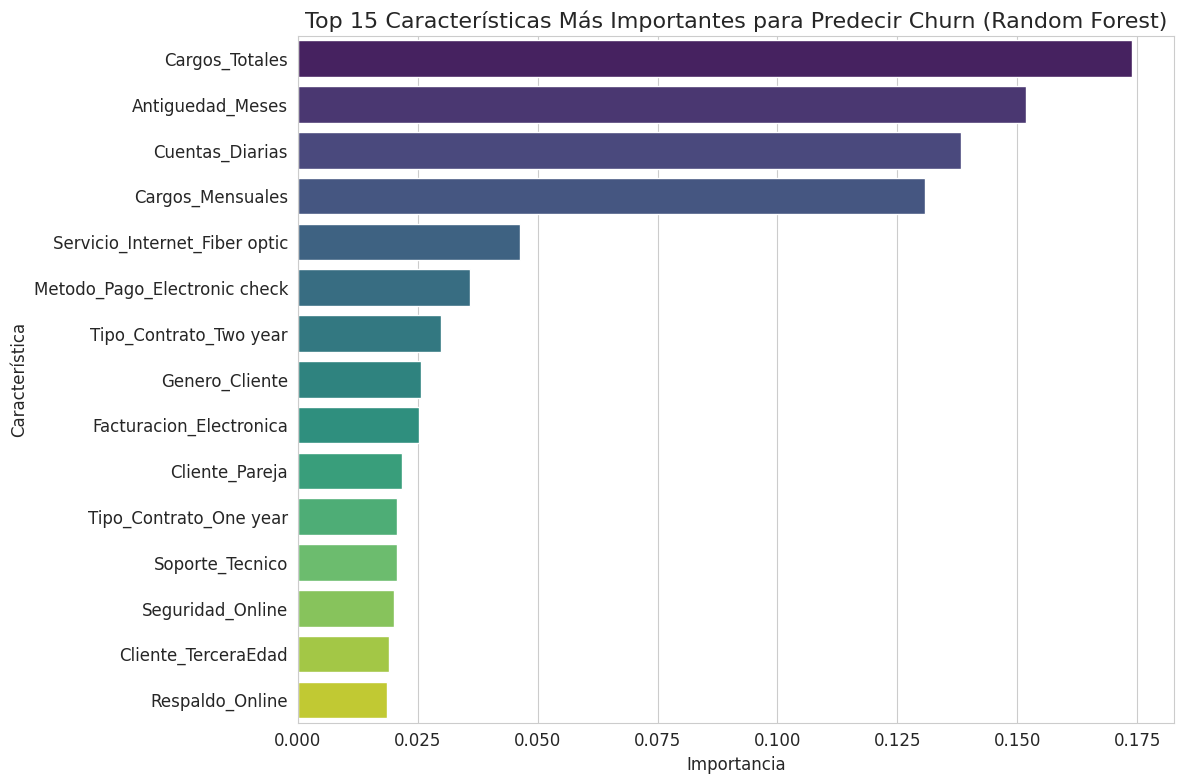


--- Coeficientes de la Regresión Logística (Influencia y Dirección) ---

Top 10 Características con mayor influencia (coeficientes) según Regresión Logística:
                  Caracteristica  Coeficiente
0               Antiguedad_Meses    -1.441002
1         Tipo_Contrato_Two year    -1.254588
2  Servicio_Internet_Fiber optic     0.841040
3           Servicio_Internet_No    -0.838852
4                 Cargos_Totales     0.691057
5         Tipo_Contrato_One year    -0.625572
6              Servicio_Telefono    -0.454688
7        Facturacion_Electronica     0.387999
8   Metodo_Pago_Electronic check     0.345821
9                Soporte_Tecnico    -0.343290


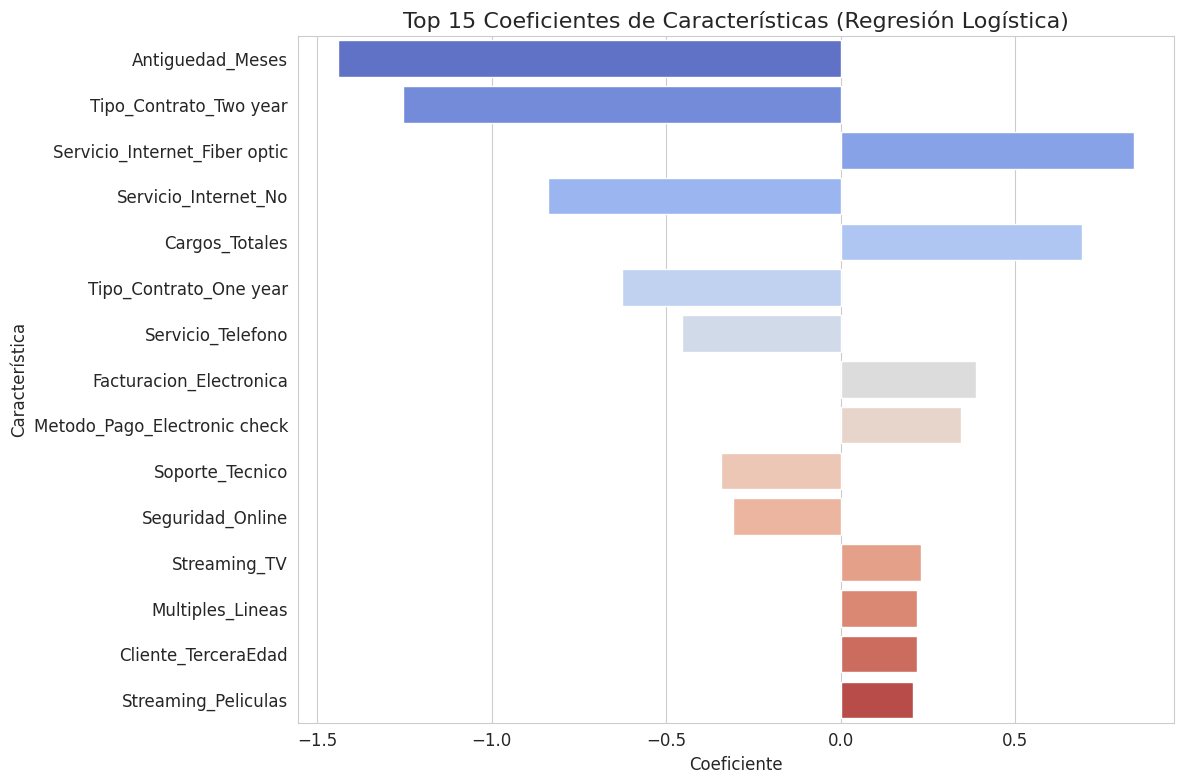

In [36]:
print("--- Paso 6: Interpretación de Resultados y Conclusiones Estratégicas ---")

# 1. Análisis de Importancia de Variables (Random Forest)
print("\n--- Importancia de las Características (Variables) según Random Forest ---")

# Asegurarse de que X_train_scaled es un DataFrame con nombres de columnas
if not isinstance(X_train_scaled, pd.DataFrame):
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)

feature_importances = rf_model.feature_importances_
importancia_df = pd.DataFrame({
    'Caracteristica': X_train_scaled.columns,
    'Importancia': feature_importances
})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

print("\nTop 15 Características más importantes para predecir Churn (Random Forest):")
print(importancia_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Caracteristica', data=importancia_df.head(15), palette='viridis')
plt.title('Top 15 Características Más Importantes para Predecir Churn (Random Forest)', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Coeficientes de Regresión Logística (para entender la dirección de la influencia)
print("\n--- Coeficientes de la Regresión Logística (Influencia y Dirección) ---")
coeficientes_df = pd.DataFrame({
    'Caracteristica': X_train_scaled.columns,
    'Coeficiente': log_reg_model.coef_[0]
})
coeficientes_df['Abs_Coeficiente'] = coeficientes_df['Coeficiente'].abs()
coeficientes_df = coeficientes_df.sort_values(by='Abs_Coeficiente', ascending=False).reset_index(drop=True)

print("\nTop 10 Características con mayor influencia (coeficientes) según Regresión Logística:")
print(coeficientes_df.drop('Abs_Coeficiente', axis=1).head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Coeficiente', y='Caracteristica', data=coeficientes_df.head(15), palette='coolwarm')
plt.title('Top 15 Coeficientes de Características (Regresión Logística)', fontsize=16)
plt.xlabel('Coeficiente', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.tight_layout()
plt.show()

In [38]:

import pandas as pd
import os

if not os.path.exists('data/processed'):
    os.makedirs('data/processed')
    print("Carpeta 'data/processed' creada.")
else:
    print("Carpeta 'data/processed' ya existe.")

# --- 2. Definir la ruta completa para el archivo CSV ---
output_csv_path = 'data/processed/df_clientes_processed.csv'

# --- 3. Guardar el DataFrame como CSV ---
df_clientes.to_csv(output_csv_path, index=False)

print(f"\nDataFrame guardado exitosamente en: {output_csv_path}")

Carpeta 'data/processed' creada.

DataFrame guardado exitosamente en: data/processed/df_clientes_processed.csv
